In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda,Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Input,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [ ]:
train=pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/train.csv')
test=pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/test.csv')
base='/content/drive/My Drive/Colab Notebooks/dataset'
train_dir=os.path.join(str(base)+'/train/')
test_dir=os.path.join(str(base)+'/test/')
train_fnames=os.listdir(train_dir)
test_fnames=os.listdir(test_dir)

In [ ]:
img_width=224
img_height=224
def train_data_preparation(list_of_images,train,train_dir):
    x=[]#Array of images
    y=[]# labels
    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(train_dir+image),(img_width,img_height),interpolation=cv2.INTER_CUBIC))
        if image in list(train['Image']):
            y.append(train.loc[train['Image']==image,'target'].values[0])
    return x,y
import cv2
training_data,training_labels=train_data_preparation(train_fnames,train,train_dir)
def test_prepare_data(list_of_images,test_dir):
    x=[]
    for image in list_of_images:
        
        x.append(cv2.resize(cv2.imread(test_dir+image),(224,224),interpolation=cv2.INTER_CUBIC))
    return x    
testing_data=test_prepare_data(test['Image'].values,test_dir)

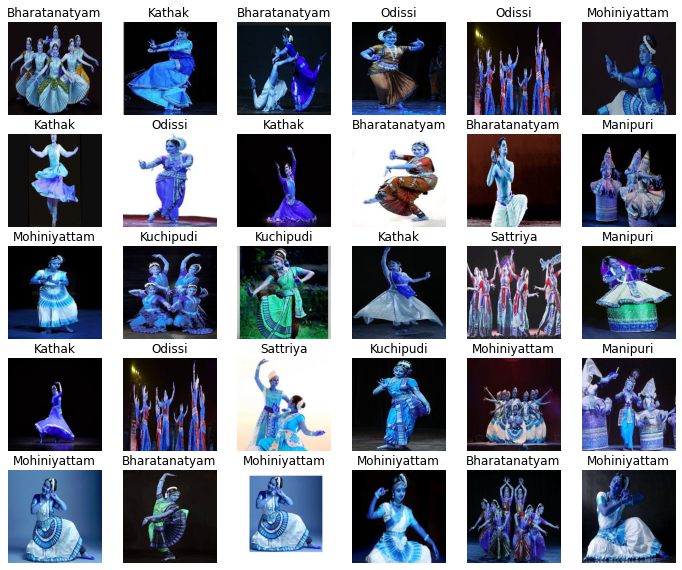

In [ ]:
def show_batch(image_batch,image_label):
    plt.figure(figsize=(12,12))
    for n in range(30):
        ax=plt.subplot(6,6,n+1)
        plt.imshow(image_batch[n])
        plt.title(image_label[n].title())
        plt.axis('off')
show_batch(training_data,training_labels)

In [ ]:
le=LabelEncoder()
training_labels=le.fit_transform(training_labels)
training_labels
to_categorical(training_labels,8)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(training_data,training_labels,test_size=0.33,random_state=42)
#Data Augmentation
train_datagenerator=ImageDataGenerator(rescale=1./255,
                                      featurewise_center=False,
                                      samplewise_center=False,
                                      rotation_range=40,
                                      zoom_range=0.20,
                                      width_shift_range=0.10,
                                       height_shift_range=0.10,
                                       horizontal_flip=True,
                                       vertical_flip=False)

test_datagenerator=ImageDataGenerator(rescale=1./255)


train_datagenerator.fit(X_train)
test_datagenerator.fit(X_test)
test_datagenerator.fit(testing_data)

X_train=np.array(X_train)
testing_data=np.array(testing_data)
X_test=np.array(X_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(243, 224, 224, 3)
(121, 224, 224, 3)
(243,)
(121,)


In [ ]:
training_data = np.array(training_data)/255.

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False 

x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(8, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
# training the model 
reduce_learning_rate=ReduceLROnPlateau(monitor='loss',
                                      factor=0.5,
                                      patience=4,
                                      min_lr=0.000001,
                                      verbose=1)
# opt = Adam(lr=0.001)
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# fitting the model 
history=model.fit(np.array(training_data), to_categorical(training_labels,8), validation_split=0.2,
                            batch_size=16,verbose=2,epochs=70,callbacks=[reduce_learning_rate]
                  )
# callbacks=[reduce_learning_rate]
# history = model.fit(X_train,to_categorical(y_train,8),validation_data=[X_test,to_categorical(y_test,8)], 
#                     epochs=15,batch_size=16,shuffle=True,verbose=2)

Epoch 1/70
19/19 - 1s - loss: 7.0849 - accuracy: 0.1271 - val_loss: 2.0828 - val_accuracy: 0.1507 - lr: 0.0010
Epoch 2/70
19/19 - 1s - loss: 4.6344 - accuracy: 0.1306 - val_loss: 2.1204 - val_accuracy: 0.1096 - lr: 0.0010
Epoch 3/70
19/19 - 1s - loss: 3.2603 - accuracy: 0.1615 - val_loss: 2.0030 - val_accuracy: 0.2740 - lr: 0.0010
Epoch 4/70
19/19 - 1s - loss: 2.5431 - accuracy: 0.1409 - val_loss: 2.0696 - val_accuracy: 0.1233 - lr: 0.0010
Epoch 5/70
19/19 - 1s - loss: 2.3527 - accuracy: 0.1581 - val_loss: 2.0687 - val_accuracy: 0.1096 - lr: 0.0010
Epoch 6/70
19/19 - 1s - loss: 2.2529 - accuracy: 0.1306 - val_loss: 2.0801 - val_accuracy: 0.1096 - lr: 0.0010
Epoch 7/70
19/19 - 1s - loss: 2.2481 - accuracy: 0.1581 - val_loss: 2.0765 - val_accuracy: 0.1507 - lr: 0.0010
Epoch 8/70
19/19 - 1s - loss: 2.0812 - accuracy: 0.1959 - val_loss: 2.0299 - val_accuracy: 0.2329 - lr: 0.0010
Epoch 9/70
19/19 - 1s - loss: 2.0127 - accuracy: 0.2199 - val_loss: 2.0283 - val_accuracy: 0.2466 - lr: 0.0010
E

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


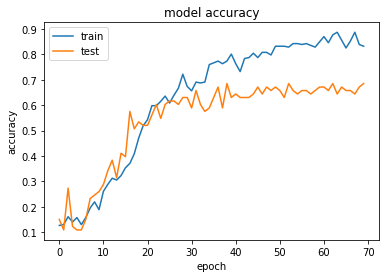

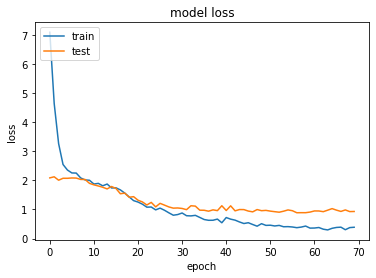

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(np.array(X_test),to_categorical(y_test,8),batch_size=16)

8/8 [==============================] - 0s 43ms/step - loss: 13.3158 - accuracy: 0.8347


[13.315831184387207, 0.8347107172012329]

In [ ]:
np.argmax(model.predict(np.array(testing_data)),axis=1)
# model.predict(np.array(testing_data))

array([2, 2, 6, 2, 0, 6, 6, 2, 7, 6, 6, 0, 7, 7, 7, 0, 2, 1, 5, 6, 6, 2,
       2, 6, 5, 2, 7, 2, 2, 0, 5, 3, 2, 0, 5, 2, 6, 6, 4, 6, 1, 6, 6, 7,
       5, 5, 2, 2, 2, 6, 5, 6, 1, 7, 1, 2, 2, 6, 6, 0, 2, 4, 6, 6, 2, 5,
       2, 6, 6, 0, 2, 6, 2, 6, 6, 2, 6, 6, 2, 1, 5, 1, 6, 6, 6, 5, 5, 7,
       2, 2, 4, 1, 0, 0, 0, 0, 3, 2, 6, 6, 4, 2, 1, 6, 1, 6, 2, 6, 4, 6,
       1, 2, 6, 6, 3, 6, 2, 2, 6, 2, 6, 6, 6, 5, 6, 5, 3, 5, 6, 6, 0, 5,
       0, 2, 4, 2, 2, 6, 2, 1, 2, 1, 4, 2, 6, 2, 6, 5, 4, 6, 2, 7, 2, 1,
       6, 7])

In [ ]:
out

array(['kathakali', 'kathakali', 'bharatanatyam', 'kathakali',
       'bharatanatyam', 'kuchipudi', 'odissi', 'kathakali', 'kuchipudi',
       'odissi', 'bharatanatyam', 'kathakali', 'sattriya', 'kathakali',
       'sattriya', 'bharatanatyam', 'sattriya', 'kathak', 'mohiniyattam',
       'bharatanatyam', 'odissi', 'kathakali', 'kathakali', 'odissi',
       'mohiniyattam', 'kathakali', 'sattriya', 'bharatanatyam', 'kathak',
       'bharatanatyam', 'kuchipudi', 'kuchipudi', 'kathak',
       'bharatanatyam', 'mohiniyattam', 'kathakali', 'odissi', 'odissi',
       'kathak', 'bharatanatyam', 'kathak', 'odissi', 'sattriya',
       'kuchipudi', 'mohiniyattam', 'kuchipudi', 'kathakali', 'sattriya',
       'kathakali', 'bharatanatyam', 'mohiniyattam', 'sattriya', 'kathak',
       'kuchipudi', 'kathak', 'kathakali', 'sattriya', 'odissi',
       'kathakali', 'bharatanatyam', 'kathakali', 'manipuri', 'odissi',
       'kuchipudi', 'sattriya', 'bharatanatyam', 'kathakali',
       'bharatanatyam', 'o

In [ ]:
out1 = le.inverse_transform(np.argmax(model.predict(np.array(testing_data)),axis=1))
out1

array(['kathakali', 'kathakali', 'odissi', 'kathakali', 'bharatanatyam',
       'odissi', 'odissi', 'kathakali', 'sattriya', 'odissi', 'odissi',
       'bharatanatyam', 'sattriya', 'sattriya', 'sattriya',
       'bharatanatyam', 'kathakali', 'kathak', 'mohiniyattam', 'odissi',
       'odissi', 'kathakali', 'kathakali', 'odissi', 'mohiniyattam',
       'kathakali', 'sattriya', 'kathakali', 'kathakali', 'bharatanatyam',
       'mohiniyattam', 'kuchipudi', 'kathakali', 'bharatanatyam',
       'mohiniyattam', 'kathakali', 'odissi', 'odissi', 'manipuri',
       'odissi', 'kathak', 'odissi', 'odissi', 'sattriya', 'mohiniyattam',
       'mohiniyattam', 'kathakali', 'kathakali', 'kathakali', 'odissi',
       'mohiniyattam', 'odissi', 'kathak', 'sattriya', 'kathak',
       'kathakali', 'kathakali', 'odissi', 'odissi', 'bharatanatyam',
       'kathakali', 'manipuri', 'odissi', 'odissi', 'kathakali',
       'mohiniyattam', 'kathakali', 'odissi', 'odissi', 'bharatanatyam',
       'kathakali', 'odi

In [ ]:
test.head()

,Image,target
0,508.jpg,kathakali
1,246.jpg,kathakali
2,473.jpg,odissi
3,485.jpg,kathakali
4,128.jpg,bharatanatyam


In [ ]:
test['target'] = out1
test.head()

,Image,target
0,508.jpg,kathakali
1,246.jpg,kathakali
2,473.jpg,odissi
3,485.jpg,kathakali
4,128.jpg,bharatanatyam


In [ ]:
test.to_csv('/content/drive/My Drive/Colab Notebooks/dataset/sample.csv',index=False)